In [40]:
import numpy as np
import pandas as pd 
import torch 
import torch.nn as nn
import torch.nn.functional as F
import os

In [41]:
#load data
path ='D:\ML_data_sql\ml-100k'
column = ['user id','movie id','rating','timestamp']
data = pd.read_csv(os.path.join(path,'u.data'),delimiter='\t',header=None,names=column)
data.head()

,user id,movie id,rating,timestamp
0,196,242,3,881250949
1,186,302,3,891717742
2,22,377,1,878887116
3,244,51,2,880606923
4,166,346,1,886397596


In [42]:
#load user data
users = pd.read_csv(os.path.join(path,'u.user'), 
                    sep="|", encoding='latin-1', header=None)
users.columns = ['user id', 'age', 'gender', 'occupation', 'zip code']
users.head()

,user id,age,gender,occupation,zip code
0,1,24,M,technician,85711
1,2,53,F,other,94043
2,3,23,M,writer,32067
3,4,24,M,technician,43537
4,5,33,F,other,15213


In [43]:
#Load movie data
items = pd.read_csv(os.path.join(path,'u.item'), 
                    sep="|", encoding='latin-1', header=None)
items.columns = ['movie id', 'movie title' ,'release date','video release date', 'IMDb URL', 
                 'unknown', 'Action', 'Adventure', 'Animation', 'Children\'s', 'Comedy', 
                 'Crime', 'Documentary', 'Drama', 'Fantasy', 'Film-Noir', 'Horror', 
                 'Musical', 'Mystery', 'Romance', 'Sci-Fi', 'Thriller', 'War', 'Western']
items.head()

,movie id,movie title,release date,video release date,IMDb URL,unknown,Action,Adventure,Animation,Children's,...,Fantasy,Film-Noir,Horror,Musical,Mystery,Romance,Sci-Fi,Thriller,War,Western
0,1,Toy Story (1995),01-Jan-1995,NaN,http://us.imdb.com/M/title-exact?Toy%20Story%2...,0,0,0,1,1,...,0,0,0,0,0,0,0,0,0,0
1,2,GoldenEye (1995),01-Jan-1995,NaN,http://us.imdb.com/M/title-exact?GoldenEye%20(...,0,1,1,0,0,...,0,0,0,0,0,0,0,1,0,0
2,3,Four Rooms (1995),01-Jan-1995,NaN,http://us.imdb.com/M/title-exact?Four%20Rooms%...,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0
3,4,Get Shorty (1995),01-Jan-1995,NaN,http://us.imdb.com/M/title-exact?Get%20Shorty%...,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,5,Copycat (1995),01-Jan-1995,NaN,http://us.imdb.com/M/title-exact?Copycat%20(1995),0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0


In [44]:
#类型
GENRES = pd.read_csv(os.path.join(path,'u.genre'), sep="|", header=None, usecols=[0])[0].tolist()
GENRES

['unknown',
 'Action',
 'Adventure',
 'Animation',
 "Children's",
 'Comedy',
 'Crime',
 'Documentary',
 'Drama',
 'Fantasy',
 'Film-Noir',
 'Horror',
 'Musical',
 'Mystery',
 'Romance',
 'Sci-Fi',
 'Thriller',
 'War',
 'Western']

## Watch the data to make model 

In [45]:
print(
    (f"Number of users: {users['user id'].nunique()}\n" 
    f"Nuber of movies: {items['movie id'].nunique()}")
)

Number of users: 943
Nuber of movies: 1682


### 看出4分最多，5分较少

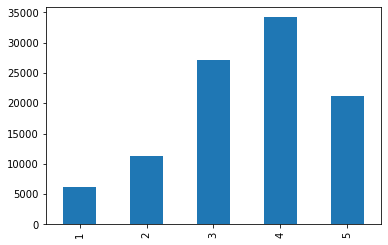

In [46]:
data['rating'].value_counts().sort_index().plot.bar()


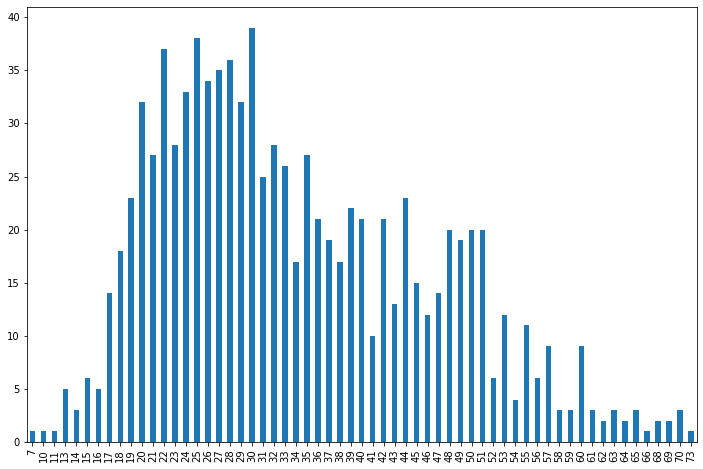

In [47]:
users['age'].value_counts().sort_index().plot.bar(figsize=(12, 8))
#20-30岁居多

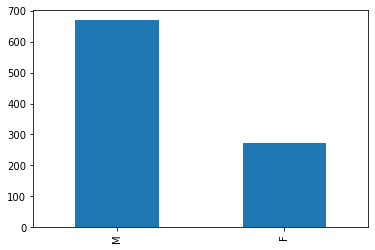

In [48]:
users['gender'].value_counts().plot.bar()
#男多女少

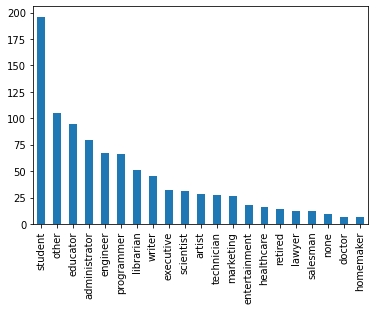

In [49]:
users['occupation'].value_counts().plot.bar()
#学生，教育工作最多

### build the fearture and  target
 target 为 用户预测的下一个电影， 需要用到特征：用户历史

In [50]:
dataset = data.sort_values(['user id', 'timestamp']).reset_index(drop=True)#查看过没有空的 没有drop
dataset['one'] = 1
dataset['sample_num'] = dataset.groupby('user id')['one'].cumsum()#求和
dataset['target'] = dataset.groupby('user id')['movie id'].shift(-1)
dataset['mean_rate'] = dataset.groupby('user id')['rating'].cumsum() / dataset['sample_num']

dataset.head()

,user id,movie id,rating,timestamp,one,sample_num,target,mean_rate
0,1,168,5,874965478,1,1,172.0,5.00
1,1,172,5,874965478,1,2,165.0,5.00
2,1,165,5,874965518,1,3,156.0,5.00
3,1,156,4,874965556,1,4,196.0,4.75
4,1,196,5,874965677,1,5,166.0,4.80


In [51]:
dataset.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 8 columns):
 #   Column      Non-Null Count   Dtype  
---  ------      --------------   -----  
 0   user id     100000 non-null  int64  
 1   movie id    100000 non-null  int64  
 2   rating      100000 non-null  int64  
 3   timestamp   100000 non-null  int64  
 4   one         100000 non-null  int64  
 5   sample_num  100000 non-null  int64  
 6   target      99057 non-null   float64
 7   mean_rate   100000 non-null  float64
dtypes: float64(2), int64(6)
memory usage: 6.1 MB


In [52]:
#build user history
dataset['prev movies'] = dataset['movie id'].apply(lambda x: str(x))
dataset['prev movies'] = dataset.groupby('user id')['prev movies'].apply(lambda x: (x + ' ').cumsum().str.strip())
dataset['prev movies'] = dataset['prev movies'].apply(lambda x: x.split())
dataset.head()

,user id,movie id,rating,timestamp,one,sample_num,target,mean_rate,prev movies
0,1,168,5,874965478,1,1,172.0,5.00,[168]
1,1,172,5,874965478,1,2,165.0,5.00,"[168, 172]"
2,1,165,5,874965518,1,3,156.0,5.00,"[168, 172, 165]"
3,1,156,4,874965556,1,4,196.0,4.75,"[168, 172, 165, 156]"
4,1,196,5,874965677,1,5,166.0,4.80,"[168, 172, 165, 156, 196]"


In [53]:
dataset = dataset.merge(items[['movie id'] + GENRES], on='movie id', how='left')
for genre in GENRES:
    dataset[f'{genre}_rate'] = dataset[genre]*dataset['rating']
    dataset[genre] = dataset.groupby('user id')[genre].cumsum()
    dataset[f'{genre}_rate'] = dataset.groupby('user id')[f'{genre}_rate'].cumsum() / dataset[genre]

dataset[GENRES] = dataset[GENRES].apply(lambda x: x / dataset['sample_num'])
dataset.head()

,user id,movie id,rating,timestamp,one,sample_num,target,mean_rate,prev movies,unknown,...,Fantasy_rate,Film-Noir_rate,Horror_rate,Musical_rate,Mystery_rate,Romance_rate,Sci-Fi_rate,Thriller_rate,War_rate,Western_rate
0,1,168,5,874965478,1,1,172.0,5.00,[168],0.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,1,172,5,874965478,1,2,165.0,5.00,"[168, 172]",0.0,...,NaN,NaN,NaN,NaN,NaN,5.0,5.0,NaN,5.0,NaN
2,1,165,5,874965518,1,3,156.0,5.00,"[168, 172, 165]",0.0,...,NaN,NaN,NaN,NaN,NaN,5.0,5.0,NaN,5.0,NaN
3,1,156,4,874965556,1,4,196.0,4.75,"[168, 172, 165, 156]",0.0,...,NaN,NaN,NaN,NaN,NaN,5.0,5.0,4.0,5.0,NaN
4,1,196,5,874965677,1,5,166.0,4.80,"[168, 172, 165, 156, 196]",0.0,...,NaN,NaN,NaN,NaN,NaN,5.0,5.0,4.0,5.0,NaN


In [54]:
#性别 和职业
dataset = dataset.merge(users, on='user id', how='left')
dataset['gender'] = (dataset['gender'] == 'M').astype(int)
dataset = pd.concat([dataset.drop('occupation', axis=1), pd.get_dummies(dataset['occupation'])], axis=1)
dataset.drop('other', axis=1, inplace=True)
dataset.drop('zip code', axis=1, inplace=True)
dataset.head()

,user id,movie id,rating,timestamp,one,sample_num,target,mean_rate,prev movies,unknown,...,librarian,marketing,none,programmer,retired,salesman,scientist,student,technician,writer
0,1,168,5,874965478,1,1,172.0,5.00,[168],0.0,...,0,0,0,0,0,0,0,0,1,0
1,1,172,5,874965478,1,2,165.0,5.00,"[168, 172]",0.0,...,0,0,0,0,0,0,0,0,1,0
2,1,165,5,874965518,1,3,156.0,5.00,"[168, 172, 165]",0.0,...,0,0,0,0,0,0,0,0,1,0
3,1,156,4,874965556,1,4,196.0,4.75,"[168, 172, 165, 156]",0.0,...,0,0,0,0,0,0,0,0,1,0
4,1,196,5,874965677,1,5,166.0,4.80,"[168, 172, 165, 156, 196]",0.0,...,0,0,0,0,0,0,0,0,1,0


In [70]:
dataset.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 100000 entries, 0 to 99999
Data columns (total 69 columns):
 #   Column            Non-Null Count   Dtype  
---  ------            --------------   -----  
 0   user id           100000 non-null  int64  
 1   movie id          100000 non-null  int64  
 2   rating            100000 non-null  int64  
 3   timestamp         100000 non-null  int64  
 4   one               100000 non-null  int64  
 5   sample_num        100000 non-null  int64  
 6   target            99057 non-null   float64
 7   mean_rate         100000 non-null  float64
 8   prev movies       100000 non-null  object 
 9   unknown           100000 non-null  float64
 10  Action            100000 non-null  float64
 11  Adventure         100000 non-null  float64
 12  Animation         100000 non-null  float64
 13  Children's        100000 non-null  float64
 14  Comedy            100000 non-null  float64
 15  Crime             100000 non-null  float64
 16  Documentary       100

In [55]:
#获取变成稀疏矩阵的索引
def get_coo_indexes(lil):
    rows = []
    cols = []
    for i, el in enumerate(lil):
        if type(el)!=list:
            el = [el]
        for j in el:
            rows.append(i)
            cols.append(j)
    return rows, cols

In [73]:
from scipy.sparse import coo_matrix
import numpy as np
#变换成稀疏矩阵
def get_sparse_features(series, shape):
    #获取索引
    coo_indexes = get_coo_indexes(series.tolist())
    #按照索引的顺序 进行填充0矩阵
    sparse_df = coo_matrix((np.ones(len(coo_indexes[0])), (coo_indexes[0], coo_indexes[1])), shape=shape)
    return sparse_df

In [75]:
coomax = get_sparse_features(dataset['prev movies'], (len(dataset), dataset['movie id'].max()+1))


(100000, 1683) <class 'scipy.sparse.coo.coo_matrix'>


#### Data split

In [58]:
#因为使用到了时间戳 所以不用自动划分的函数
#参数设置
COLD_START_TRESH = 5    #冷启动
TEST_SIZE = 0.2

In [59]:
filtred_data = dataset[(dataset['sample_num'] >= COLD_START_TRESH) &
                       ~(dataset['target'].isna())].sort_values('timestamp')    #时间排序,去除没有target的 
train_data = filtred_data[:int(len(filtred_data)*(1-TEST_SIZE))]
test_data = filtred_data[int(len(filtred_data)*(1-TEST_SIZE)):]
train_data.shape, test_data.shape

((76228, 69), (19057, 69))

In [60]:
pd.concat([data['user id'].value_counts().describe(),
           train_data['user id'].value_counts().describe(),
           test_data['user id'].value_counts().describe()],
         axis=1,
         keys=['total', 'train', 'test'])

,total,train,test
count,943.000000,748.000000,295.000000
mean,106.044539,101.909091,64.600000
std,100.931743,99.935734,79.619691
min,20.000000,4.000000,1.000000
25%,33.000000,29.000000,16.000000
50%,65.000000,61.000000,31.000000
75%,148.000000,145.000000,92.500000
max,737.000000,732.000000,475.000000


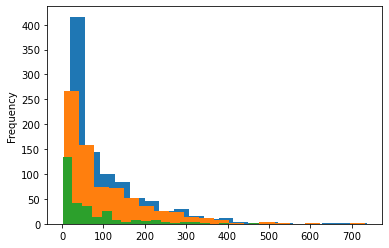

In [61]:
for df in [data, train_data, test_data]:
    df.groupby('user id')['movie id'].count().plot.hist(bins=20)

In [62]:
print((
    f"Total movies: {data['movie id'].nunique()}\n" #返回唯一值的个数
    f"Movies in train: {train_data['movie id'].nunique()}\n"
    f"Movies in test: {test_data['movie id'].nunique()}\n"
))  

Total movies: 1682
Movies in train: 1611
Movies in test: 1442



In [63]:
X_train = train_data.drop(['user id','movie id','rating','timestamp',
                    'one','sample_num','target','prev movies'],axis=1)
prev_movies_train = get_sparse_features(train_data['prev movies'],(len(train_data),dataset['movie id'].max()+1))

y_train = train_data['target']
X_test = test_data.drop(['user id','movie id','rating','timestamp',
                    'one','sample_num','target','prev movies'],axis=1)
prev_movies_test =get_sparse_features(test_data['prev movies'],(len(test_data),dataset['movie id'].max()+1))
y_test =test_data['target']

In [77]:
print(X_train.shape)
X_train.head()
y_train[:5]

(76228, 61)


25423    772.0
25425    288.0
25424    108.0
25426    928.0
25427    117.0
Name: target, dtype: float64

In [64]:
#baseline LightGBM
import lightgbm as lgb
params = {
    'objective':'softmax', 
    'num_class':items['movie id'].nunique()+1, 
    'num_iterations':10, 
    'verbose':-1
}
train_data =lgb.Dataset(X_train.reset_index(drop=True),label=y_train,free_raw_data=False)
movies_data_train = lgb.Dataset(prev_movies_train,free_raw_data=False)
train_data = train_data.construct()
movies_data_train = movies_data_train.construct()
train_data = train_data.add_features_from(movies_data_train)
model = lgb.train(params,train_data)


C:\develop\Python\Python38\lib\site-packages\lightgbm\basic.py:1973: UserWarning: Reseting categorical features.
You can set new categorical features via ``set_categorical_feature`` method
  warnings.warn("Reseting categorical features.\n"
C:\develop\Python\Python38\lib\site-packages\lightgbm\engine.py:151: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


In [79]:
test_data = lgb.Dataset(X_test.reset_index(drop=True), free_raw_data=False)
movies_data_test = lgb.Dataset(prev_movies_test, free_raw_data=False)
test_data = test_data.construct()
movies_data_test = movies_data_test.construct()
test_data = test_data.add_features_from(movies_data_test)
preds_baseline = model.predict(test_data.get_data())
print(preds_baseline.shape)

C:\develop\Python\Python38\lib\site-packages\lightgbm\basic.py:1973: UserWarning: Reseting categorical features.
You can set new categorical features via ``set_categorical_feature`` method
  warnings.warn("Reseting categorical features.\n"


(19057, 1683)


In [80]:
for i in range(len(preds_baseline[0])):
    if preds_baseline[0][i]!=0:
        print(i)
        print(preds_baseline[0][i])


156
7.14353800918326e-195
184
7.934287502607587e-285
226
2.9591540218663796e-285
367
1.541756488855807e-280
515
1.0
709
1.413e-321


In [66]:
#two function
def sparse_to_idx(data,pad_idx=1):
    indexes = data.nonzero()
    indexes_df = pd.DataFrame()
    indexes_df['rows'] = indexes[0]
    indexes_df['cols'] = indexes[1]
    mdf = indexes_df.groupby('rows').apply(lambda x:x['cols'].tolist())
    max_len = mdf.apply(lambda x:len(x)).max()
    return mdf.apply(lambda x:pd.Series(x+[pad_idx]*(max_len-len(x)))).values

def idx_to_sparse(idx,sparse_dim):
    sparse = np.zeros(sparse_dim)
    sparse[int(idx)]=1
    return pd.Series(sparse,dtype=int)


In [67]:
import torch 
device = 'cuda' if torch.cuda.is_available()else 'cpu'


In [68]:
#create tensor to train
# Train part
PAD_IDX = 0
# tensor with continious features
X_train_tensor = torch.Tensor(X_train.fillna(0).values).to(device)
# tensor with sequence of indexes
movies_train_tensor = torch.sparse_coo_tensor(
    indices=prev_movies_train.nonzero(), 
    values=[1]*len(prev_movies_train.nonzero()[0]),
    size=prev_movies_train.shape
).to_dense().to(device)
# tensor with binary features
movies_train_idx = torch.Tensor(
    sparse_to_idx(prev_movies_train, pad_idx=PAD_IDX),
).long().to(device)
# target
target_train = torch.Tensor(y_train.values).long().to(device)

X_test_tensor = torch.Tensor(X_test.fillna(0).values).to(device)
# tensor with continious features
movies_test_tensor = torch.sparse_coo_tensor(
    indices=prev_movies_test.nonzero(), 
    values=[1]*len(prev_movies_test.nonzero()[0]),
    size=prev_movies_test.shape
).to_dense().to(device)
# tensor with binary features
movies_test_idx = torch.Tensor(
    sparse_to_idx(prev_movies_test, pad_idx=PAD_IDX),
).long().to(device)
# target
target_test = torch.Tensor(y_test.values).long().to(device)

RuntimeError: CUDA out of memory. Tried to allocate 430.00 MiB (GPU 0; 4.00 GiB total capacity; 2.72 GiB already allocated; 16.20 MiB free; 2.91 GiB reserved in total by PyTorch)

In [ ]:
from torch import nn,cat,mean
class WideAndDeep(nn.Module):
    def __init__(self,continious_feature_shape,embed_size,embed_dict_len, 
        pad_idx):
        super(WideAndDeep,self).__init__()
        self.embed = nn.Embedding(embed_dict_len,embed_size,padding_idx=pad_idx)
        self.linear_relu_stack = nn.Sequential(
            nn.Linear(embed_size+continious_feature_shape,1024), 
            nn.ReLU(),
            nn.Linear(1024,512), 
            nn.ReLU(), 
            nn.Linear(512,256), 
            nn.ReLU())
        self.head = nn.Sequential(
            nn.Linear(embed_dict_len+256,embed_dict_len), 
        )

    def forward(self,continious,binary,binary_idx):
        binary_embed = self.embed(binary_idx)
        binary_embed_mean = mean(binary_embed,dim=1)
        deep_logits = self.linear_relu_stack(cat(continious,binary_embed_mean),dim=1)
        total_logits = self.head(cat((deep_logits,binary),dim=1))
        return total_logits
        

In [ ]:
model = WideAndDeep(X_train.shape[1],16,items['movie id'].nunique()+1,PAD_IDX).to(device)
print(model)

In [ ]:
#train
EPOCHS = 10 
loss_fn = nn.CrossEntropyLoss(ignore_index=PAD_IDX)
optimizer = torch.optim.Adam(model.parameters(),lr=1e-3)
for  t in range(EPOCHS):
    model.train()
    pred_train = model(X_train_tensor,movies_train_tensor,movies_train_idx)
    loss_train = loss_fn(pred_train,target_train)
    optimizer.zero_grad()
    loss_train.backward()
    optimizer.step()
    
    model.eval()
    with torch.no_grad():
        pred_test = model(X_test_tensor,movies_test_tensor,movies_test_idx)
        loss_test = loss_fn(pred_test,target_test)

        print(f'EPochs{t}')
        print(f'Train loss:{loss_train:>7f}')
        print(f'Test loss:{loss_test:>7f}')
